# ML Textual model Feature Engineering

In [0]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import sklearn
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import preprocessing
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import itertools

# Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Reading CSV file using pandas dataframe

In [5]:
dataset = pd.read_csv("patient data all 119.csv")
df_clean = dataset.drop(columns=["seq_id", "patient_id", "date" , "cough_filename", "finger_filename",
                                "patient_smartphone", "breathing_filename"])
df_clean.head()

,corona_test,age,gender,medical_history,smoker,patient_reported_symptoms
0,negative,32,male,NaN,NaN,"Fever, chills, or sweating,"
1,negative,31,male,NaN,NaN,"Fever, chills, or sweating,Shortness of breath..."
2,negative,21,female,NaN,NaN,"New or worsening cough,"
3,negative,33,male,"Asthma or chronic lung disease,",NaN,"Fever, chills, or sweating,Shortness of breath..."
4,negative,27,male,Disease or conditions that make it harder to c...,NaN,"New or worsening cough,"


### Counting number of nan values in each feature

In [6]:
ff = df_clean["medical_history"].isna().sum()
print(ff)

# Filling nan values with None.
df_clean["medical_history"].fillna("None,", inplace = True) 
df_clean["smoker"].fillna("no", inplace = True) 
df_clean["patient_reported_symptoms"].fillna("None,", inplace = True) 

3


In [7]:
df_clean.head()

,corona_test,age,gender,medical_history,smoker,patient_reported_symptoms
0,negative,32,male,"None,",no,"Fever, chills, or sweating,"
1,negative,31,male,"None,",no,"Fever, chills, or sweating,Shortness of breath..."
2,negative,21,female,"None,",no,"New or worsening cough,"
3,negative,33,male,"Asthma or chronic lung disease,",no,"Fever, chills, or sweating,Shortness of breath..."
4,negative,27,male,Disease or conditions that make it harder to c...,no,"New or worsening cough,"


In [9]:
# In order to see how many unique values are there in my column
df_clean["medical_history"].describe()

count       124
unique       11
top       None,
freq         84
Name: medical_history, dtype: object

### Histogram

<Figure size 432x288 with 0 Axes>

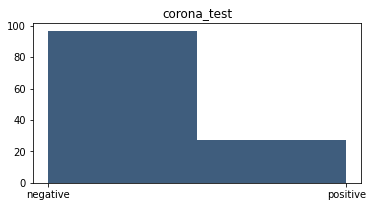

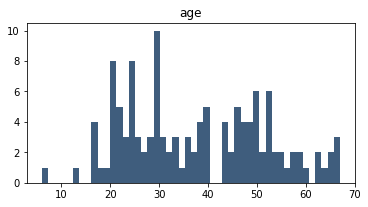

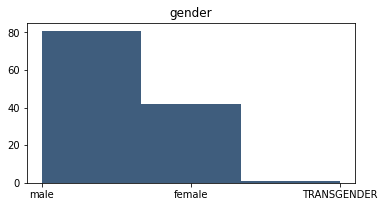

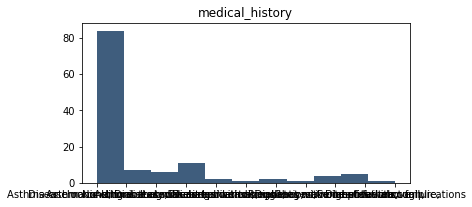

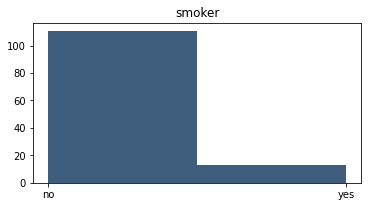

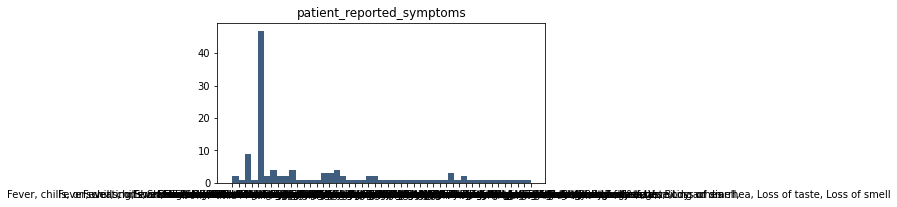

In [10]:
plt.suptitle("Histogram of Numerical Columns", fontsize = 20)
for i in range(1, df_clean.shape[1]+ 1): 
    plt.figure(figsize=(20,10))
    plt.subplot(3, 3, i)
    f = plt.gca()
    f.set_title(df_clean.columns.values[i - 1])
    vals = np.size(df_clean.iloc[:, i - 1].unique())
    plt.hist(df_clean.iloc[:, i - 1], bins = vals, color = "#3F5D7D")

# Correlation

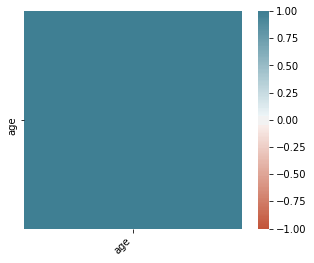

In [12]:
# TODO: Not working properly

# df_clean.corrwith(df_clean.corona_test).plot.bar(figsize = (20, 10),
#                                                 title= "Correlation With Responsive Variable", 
#                                                 fontsize = 15, rot = 45,
#                                                 grid = True)
corr = df_clean.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [13]:
# For checking the data type of all the features
df_clean.dtypes

corona_test                  object
age                           int64
gender                       object
medical_history              object
smoker                       object
patient_reported_symptoms    object
dtype: object

In [35]:
# For checking how many unique rows in medical history.
df_clean["medical_history"].unique()

array(['None,', 'Asthma or chronic lung disease,',
       'Disease or conditions that make it harder to cough,',
       'Diabetes with complications,',
       'Asthma or chronic lung disease,Disease or conditions that make it harder to cough,',
       'Asthma or chronic lung disease,Diabetes with complications,',
       'Pregnancy,',
       'Diabetes with complications,Congestive heart failure,',
       'Congestive heart failure,', 'none of the above',
       'Diabetes with complications'], dtype=object)

### reading csv containing important medical history diseases

In [36]:
top_medical_history = pd.read_csv("medical_history.csv").medical_history.values
top_medical_history

array(['None,', 'Asthma or chronic lung disease,',
       'Disease or conditions that make it harder to cough,',
       'Diabetes with complications,', 'Pregnancy,',
       'Congestive heart failure,', 'Extreme obesity'], dtype=object)

### doing feature engineering on medical history

In [40]:
df2 = df_clean.copy()
for mh in top_medical_history:
    df2[mh] = df2.medical_history.str.contains(mh).astype(int)
    df2["medical_history"] = df2.medical_history.str.replace(mh+ ",", "")

df2["total_diseases"] = df2.medical_history.str.count(",")
df2 = df2.drop(columns = ["medical_history", "patient_reported_symptoms"])
df2

,corona_test,age,gender,smoker,"None,","Asthma or chronic lung disease,","Disease or conditions that make it harder to cough,","Diabetes with complications,","Pregnancy,","Congestive heart failure,",Extreme obesity,total_diseases
0,negative,32,male,no,1,0,0,0,0,0,0,1
1,negative,31,male,no,1,0,0,0,0,0,0,1
2,negative,21,female,no,1,0,0,0,0,0,0,1
3,negative,33,male,no,0,1,0,0,0,0,0,1
4,negative,27,male,no,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
119,negative,25,female,yes,0,0,0,0,0,0,0,0
120,negative,30,male,no,0,0,0,0,0,0,0,0
121,positive,36,male,no,0,0,0,0,0,0,0,0
122,negative,36,male,yes,0,0,0,0,0,0,0,0


# Doing feature engineering on reported Symptoms

In [0]:
# For checking how many unique rows in patient_reported_symptoms.
# df_clean["patient_reported_symptoms"].unique()

In [41]:
# reading csv_file of patient recorded symptoms
top_symptoms = pd.read_csv("patient_reported_symptoms.csv").patient_reported_symptoms.values
top_symptoms

array(['Fever,', 'chills,', 'or sweating,', 'Shortness of breath',
       'Loss of taste,', 'Loss of smell,', 'New or worsening cough,',
       'Sore throat,', 'Body aches,', 'None,'], dtype=object)

#### Breaking every symptom into a feature

In [43]:
df3 = df_clean.copy()
for ps in top_symptoms:
    df3[ps] = df_clean.patient_reported_symptoms.str.contains(ps).astype(int)
    df3["patient_reported_symptoms"] = df_clean.patient_reported_symptoms.str.replace(ps+ ",", "")

df3["total symptoms"] = df_clean.patient_reported_symptoms.str.count(",")
df3 = df3.drop(columns = ["patient_reported_symptoms", "medical_history", "corona_test", "age", "gender", "smoker"])

df3.rename(columns={'None,':'Nothing'}, 
                 inplace=True)
df3

,"Fever,","chills,","or sweating,",Shortness of breath,"Loss of taste,","Loss of smell,","New or worsening cough,","Sore throat,","Body aches,",Nothing,total symptoms
0,1,1,1,0,0,0,0,0,0,0,3
1,1,1,1,1,1,1,0,0,0,0,6
2,0,0,0,0,0,0,1,0,0,0,1
3,1,1,1,1,1,1,1,0,0,0,7
4,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
119,1,1,0,0,0,0,0,0,0,0,2
120,1,1,1,1,0,0,1,0,0,0,5
121,0,0,0,0,0,0,0,0,0,0,0
122,1,1,1,1,1,0,1,1,1,0,9


##### Here we are merging the dataframes based on these features

In [57]:
df4 = pd.concat([df2, df3], axis=1, ignore_index=False)
# here you can drop total symptoms and total diseases column as well, in order to make your algo more robust
df4 = df4.drop(columns = ["total_diseases", "total symptoms"])
df4

,corona_test,age,gender,smoker,"None,","Asthma or chronic lung disease,","Disease or conditions that make it harder to cough,","Diabetes with complications,","Pregnancy,","Congestive heart failure,",Extreme obesity,"Fever,","chills,","or sweating,",Shortness of breath,"Loss of taste,","Loss of smell,","New or worsening cough,","Sore throat,","Body aches,",Nothing
0,negative,32,male,no,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
1,negative,31,male,no,1,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0
2,negative,21,female,no,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,negative,33,male,no,0,1,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0
4,negative,27,male,no,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,negative,25,female,yes,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
120,negative,30,male,no,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0
121,positive,36,male,no,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
122,negative,36,male,yes,0,0,0,0,0,0,0,1,1,1,1,1,0,1,1,1,0


In [58]:
# for visualizing statistical detail of dataframe.
df4.describe()

,age,"None,","Asthma or chronic lung disease,","Disease or conditions that make it harder to cough,","Diabetes with complications,","Pregnancy,","Congestive heart failure,",Extreme obesity,"Fever,","chills,","or sweating,",Shortness of breath,"Loss of taste,","Loss of smell,","New or worsening cough,","Sore throat,","Body aches,",Nothing
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.0,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,37.717742,0.677419,0.080645,0.064516,0.104839,0.016129,0.040323,0.0,0.266129,0.266129,0.258065,0.314516,0.177419,0.080645,0.379032,0.298387,0.112903,0.379032
std,14.336014,0.469360,0.273394,0.246667,0.307588,0.126483,0.197513,0.0,0.443725,0.443725,0.439345,0.466207,0.383573,0.273394,0.487114,0.459406,0.317758,0.487114
min,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36.500000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,50.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,67.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [59]:
df4.dtypes

corona_test                                            object
age                                                     int64
gender                                                 object
smoker                                                 object
None,                                                   int64
Asthma or chronic lung disease,                         int64
Disease or conditions that make it harder to cough,     int64
Diabetes with complications,                            int64
Pregnancy,                                              int64
Congestive heart failure,                               int64
Extreme obesity                                         int64
Fever,                                                  int64
chills,                                                 int64
or sweating,                                            int64
Shortness of breath                                     int64
Loss of taste,                                          int64
Loss of 

In [52]:
# for checking total no of nan values in dataset.
df4.isna().sum()

corona_test                                            0
age                                                    0
gender                                                 0
smoker                                                 0
None,                                                  0
Asthma or chronic lung disease,                        0
Disease or conditions that make it harder to cough,    0
Diabetes with complications,                           0
Pregnancy,                                             0
Congestive heart failure,                              0
Extreme obesity                                        0
Fever,                                                 0
chills,                                                0
or sweating,                                           0
Shortness of breath                                    0
Loss of taste,                                         0
Loss of smell,                                         0
New or worsening cough,        

### For checking class distribution

negative    97
positive    27
Name: corona_test, dtype: int64


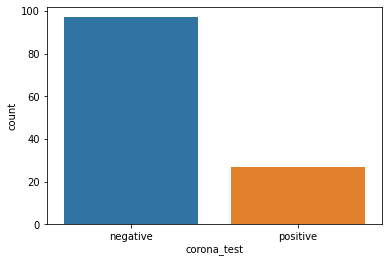

In [64]:
ax = sns.countplot(x = "corona_test", data = df4)
print(df4["corona_test"].value_counts())

pos = df4["corona_test"].value_counts()[0]
neg = df4["corona_test"].value_counts()[1]

### For checking contribution from each class in terms of percentage. 

In [66]:
neg_per = 100 *(pos / float(df4.shape[0]))
pos_per = 100 *(neg / float(df4.shape[0]))
print(neg_per)
print(pos_per)

78.2258064516129
21.774193548387096


In [68]:
# For checking distribution of values in each column or in each feature.. 

unique = df4["age"].value_counts()
print("Number of unique age values :", unique.shape[0])
# the top 10 ages that were repeated again and again
print(unique.head(10))

Number of unique age values : 48
20    6
50    6
46    5
29    5
30    5
22    5
40    5
24    5
17    4
53    4
Name: age, dtype: int64


In [69]:
# For checking distribution of values in each column or in each feature..  (checking distribution of age)

unique = df4["gender"].value_counts()
print("Number of unique age values :", unique.shape[0])
# the top 10 ages that were repeated again and again
print(unique.head(10))

Number of unique age values : 3
male           81
female         42
TRANSGENDER     1
Name: gender, dtype: int64


In [71]:
# For checking distribution of values in each column or in each feature..  (checking distribution of )
unique = df4["smoker"].value_counts()
print("Number of unique age values :", unique.shape[0])
# the top 10 ages that were repeated again and again
print(unique.head(10))

Number of unique age values : 2
no     111
yes     13
Name: smoker, dtype: int64


In [0]:
# In order to convert textural data into a numerical number for machine learning, we will use One hot encoding. 
# in pandas we have get_dummies function to convert textual data into seperate features like one hot encoder

In [0]:
gender = pd.get_dummies(df4['gender'])
smoker = pd.get_dummies(df4['smoker'], prefix='smoker')

In [75]:
# so here we are merging dataframes together
df5 = pd.concat([gender, smoker, df4], axis=1, ignore_index=False)
df5 = df5.drop(columns = ["gender", "smoker"])
df5 = df5.replace(to_replace ="negative", 
                 value =0)
df5 = df5.replace(to_replace ="positive", 
                 value =1)
# df5[df5["corona_test"] == "negative"] = 0
# df5[df5["corona_test"] == "positive"] = 1

target_labels = df5["corona_test"] 
df5 = df5.drop(columns = ["corona_test"])
df5

,TRANSGENDER,female,male,smoker_no,smoker_yes,age,"None,","Asthma or chronic lung disease,","Disease or conditions that make it harder to cough,","Diabetes with complications,","Pregnancy,","Congestive heart failure,",Extreme obesity,"Fever,","chills,","or sweating,",Shortness of breath,"Loss of taste,","Loss of smell,","New or worsening cough,","Sore throat,","Body aches,",Nothing
0,0,0,1,1,0,32,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
1,0,0,1,1,0,31,1,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0
2,0,1,0,1,0,21,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,1,1,0,33,0,1,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0
4,0,0,1,1,0,27,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,0,1,0,0,1,25,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
120,0,0,1,1,0,30,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0
121,0,0,1,1,0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
122,0,0,1,0,1,36,0,0,0,0,0,0,0,1,1,1,1,1,0,1,1,1,0


In [0]:
# Let's try SMOTE for balancing data 
# but we will just apply smote on training data
# blc testing data will remain original, no duplication in testing data. 
# so spliting the dataset

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df5, target_labels, test_size=0.30, random_state=20, shuffle=True)

### Applying SMOTE

In [78]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=0)

X_train_smote , y_train_smote = smote.fit_sample(X_train.astype("int"), y_train.astype("int"))

print("Before Smote: ", Counter(y_train))
print("After Smote: ", Counter(y_train_smote))

# so as you can say from the results that before smoting we had only 20 samples from class 1
# and we had 74 samples from class 0 so we performed smote to make them equal. 

Before Smote:  Counter({0: 68, 1: 18})
After Smote:  Counter({1: 68, 0: 68})


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# Now building the model

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Normalising train and test data
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train_smote)
X_test_scaled = min_max_scaler.fit_transform(X_test)

model = KNeighborsClassifier(n_neighbors=10)
model.fit(X_train_scaled, y_train_smote)

y_pred = model.predict(X_test_scaled)

In [87]:
y_test = np.array(y_test).astype("int")
print("Testing accuracy is: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
pd.crosstab(y_test, y_pred)

Testing accuracy is:  0.6052631578947368
              precision    recall  f1-score   support

           0       0.77      0.69      0.73        29
           1       0.25      0.33      0.29         9

    accuracy                           0.61        38
   macro avg       0.51      0.51      0.51        38
weighted avg       0.65      0.61      0.62        38



col_0,0,1
row_0,,
0,20,9
1,6,3



ROC curve value is:  0.5383141762452107
Confusion matrix, without normalization
[[20  9]
 [ 6  3]]


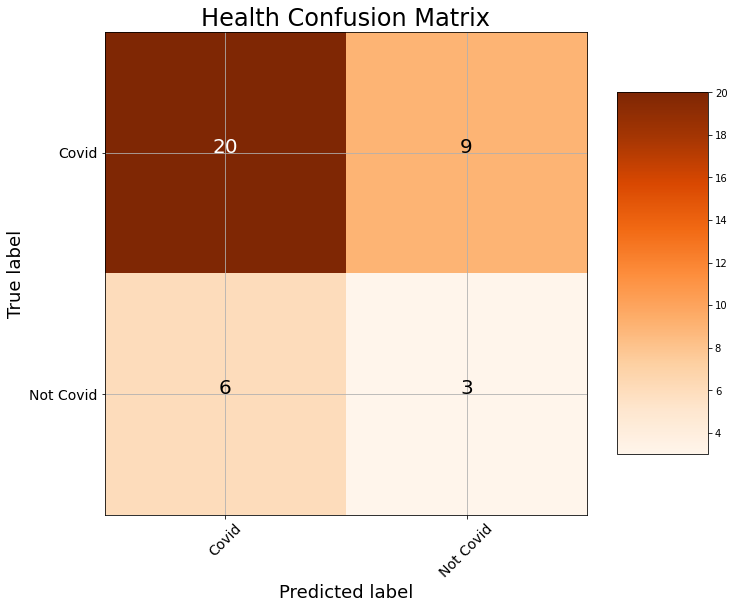

In [90]:
# Probabilities for each class
rf_probs = model.predict_proba(X_test_scaled)[:, 1]

# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)
print()
print("ROC curve value is: ", roc_value)

# Plotting confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['Covid', 'Not Covid'],
                      title = 'Health Confusion Matrix')

plt.savefig('text-cmat.png')

In [0]:
# calculate roc curve
ns_probs = [0 for _ in range(len(y_test))]

fpr, tpr, thresholds = roc_curve(y_test, rf_probs)

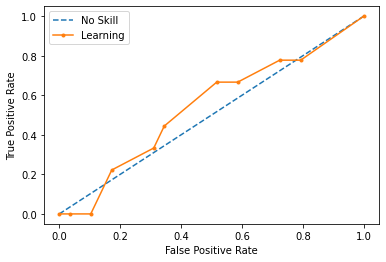

In [92]:
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, rf_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Learning')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()

### Now down here I m gonna use XGBoost
### along with RandomizedSearchCV for hyperparamter tuning

In [93]:
X_train, X_test, y_train, y_test = train_test_split(df5, target_labels, test_size=0.30, random_state=20, shuffle=True)

# doing oversampling on train data
X_train_smote , y_train_smote = smote.fit_sample(X_train.astype("int"), y_train.astype("int"))
print("Before Smote: ", Counter(y_train))
print("After Smote: ", Counter(y_train_smote))


# Normalising train and test data

min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train_smote)
X_test_scaled = min_max_scaler.fit_transform(X_test)

Before Smote:  Counter({0: 68, 1: 18})
After Smote:  Counter({1: 68, 0: 68})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [94]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost

## Hyper Parameter Optimization

params = {
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}


classifier=xgboost.XGBClassifier()

random_search=RandomizedSearchCV(classifier, param_distributions=params, n_iter=5,   
                                 scoring='roc_auc', n_jobs=-1, cv=5,verbose=3)

# n_iter defines how many times your hyperparamters combination will be tested. 

random_search_model = random_search.fit(X_train_scaled, y_train_smote)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.6s finished


In [95]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.1,
              learning_rate=0.25, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [96]:
random_search.best_params_

{'colsample_bytree': 0.4,
 'gamma': 0.1,
 'learning_rate': 0.25,
 'max_depth': 12,
 'min_child_weight': 1}

In [97]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(classifier, X_test_scaled, y_test ,cv=10)
print(score)
print(score.mean())

[0.75       0.75       0.75       0.75       0.75       0.75
 0.75       0.25       0.66666667 1.        ]
0.7166666666666667


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [0]:
classifier = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.3,
              learning_rate=0.2, max_delta_step=0, max_depth=8,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [99]:
classifier.fit(X_train_scaled, y_train_smote)

y_pred = classifier.predict(X_test_scaled)

y_test = np.array(y_test).astype("int")
# y_test
print("Testing accuracy is: ", accuracy_score(y_test, y_pred))
print(print(classification_report(y_test, y_pred)))
pd.crosstab(y_test, y_pred)

Testing accuracy is:  0.6052631578947368
              precision    recall  f1-score   support

           0       0.72      0.79      0.75        29
           1       0.00      0.00      0.00         9

    accuracy                           0.61        38
   macro avg       0.36      0.40      0.38        38
weighted avg       0.55      0.61      0.58        38

None


col_0,0,1
row_0,,
0,23,6
1,9,0



ROC curve value is:  0.5383141762452107
Confusion matrix, without normalization
[[23  6]
 [ 9  0]]


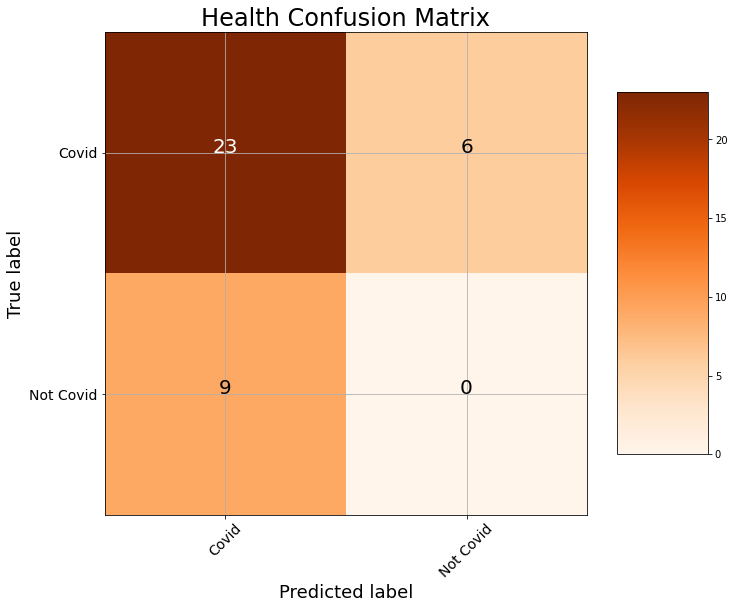

In [101]:
# Probabilities for each class
rf_probs = model.predict_proba(X_test_scaled)[:, 1]

# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)
print()
print("ROC curve value is: ", roc_value)

# Plotting confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['Covid', 'Not Covid'],
                      title = 'Health Confusion Matrix')

plt.savefig('text-cmat2.png')

##### NOTE: you can make prediction using randomized_search_hyperparameter_model as well. 

In [102]:
y_pred = random_search_model.predict(X_test_scaled)

y_test = np.array(y_test).astype("int")
# y_test
print("Testing accuracy is: ", accuracy_score(y_test, y_pred))
print(print(classification_report(y_test, y_pred)))
pd.crosstab(y_test, y_pred)

Testing accuracy is:  0.7105263157894737
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        29
           1       0.33      0.22      0.27         9

    accuracy                           0.71        38
   macro avg       0.56      0.54      0.54        38
weighted avg       0.68      0.71      0.69        38

None


col_0,0,1
row_0,,
0,25,4
1,7,2


# Spliting data into training, validation and testing.
# and trying XGBoost 

In [103]:
X_train, X_test, y_train, y_test = train_test_split(df5, target_labels, test_size=0.20, random_state=20, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=20, shuffle=True)

# doing over sampling
X_train_smote , y_train_smote = smote.fit_sample(X_train.astype("int"), y_train.astype("int"))
print("Before Smote: ", Counter(y_train))
print("After Smote: ", Counter(y_train_smote))


# Normalising train, val and test data
np.random.seed(1)
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train_smote)
X_val_scaled = min_max_scaler.fit_transform(X_val)
X_test_scaled = min_max_scaler.fit_transform(X_test)

Before Smote:  Counter({0: 52, 1: 17})
After Smote:  Counter({0: 52, 1: 52})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [104]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost

## Hyper Parameter Optimization

params = {
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}


classifier=xgboost.XGBClassifier()

random_search=RandomizedSearchCV(classifier, param_distributions=params, n_iter=5,   
                                 scoring='roc_auc', n_jobs=-1, cv=5,verbose=3)

# n_iter defines how many times your hyperparamters combination will be tested. 

random_search_model = random_search.fit(X_train_scaled, y_train_smote)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.3s finished


In [105]:
# This shows best paramter for your model
random_search_model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.0,
              learning_rate=0.25, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [106]:
# This is almost the same but less concise.
random_search_model.best_params_

{'colsample_bytree': 0.4,
 'gamma': 0.0,
 'learning_rate': 0.25,
 'max_depth': 5,
 'min_child_weight': 1}

In [0]:
classifier = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.3,
              learning_rate=0.25, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [108]:
classifier.fit(X_train_scaled, y_train_smote)

y_pred = classifier.predict(X_test_scaled)

y_test = np.array(y_test).astype("int")
# y_test
print("Testing accuracy is: ", accuracy_score(y_test, y_pred))
print(print(classification_report(y_test, y_pred)))
pd.crosstab(y_test, y_pred)

Testing accuracy is:  0.6
              precision    recall  f1-score   support

           0       0.79      0.71      0.75        21
           1       0.00      0.00      0.00         4

    accuracy                           0.60        25
   macro avg       0.39      0.36      0.38        25
weighted avg       0.66      0.60      0.63        25

None


col_0,0,1
row_0,,
0,15,6
1,4,0


# Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB

In [110]:
clf = GaussianNB()
clf.fit(X_train_scaled,y_train_smote)
print("Accuracy on test dataset: ", clf.score(X_test_scaled,y_test))

Accuracy on test dataset:  0.32


# SVM

In [0]:
from sklearn.svm import SVC

In [112]:
# with default hyper parameter
kernel = ["linear","poly","rbf","sigmoid"]
for i in kernel:
    clf = SVC(kernel = i)
    clf.fit(X_train_scaled,y_train_smote)
    pred = clf.predict(X_test_scaled)
    print("Accuracy on test dataset with",i,"kernel: ", accuracy_score(pred,y_test)) 

Accuracy on test dataset with linear kernel:  0.72
Accuracy on test dataset with poly kernel:  0.6
Accuracy on test dataset with rbf kernel:  0.76
Accuracy on test dataset with sigmoid kernel:  0.68


In [0]:
# hyper parameters for SVC
kernel = ["linear","poly","rbf","sigmoid"]
degree = [2,3,4]
gammas = [0.001, 0.01, 0.1, 1, 10, 100]
# making C list  
C=[1, 10, 100, 200, 300, 1000]


In [114]:
# trying to fit the model with different hyperparameters to achieve the highest accuracy
accuracy_history = []
for i in kernel:
    for j in degree:
        for k in gammas:
            for l in C:
                clf = SVC(kernel = i,C=l, degree = j, gamma=k,random_state=0)
                clf.fit(X_train_scaled,y_train_smote)
                pred = clf.predict(X_test_scaled)
                accuracy = accuracy_score(pred,y_test)
                print("Accuracy on test dataset with",i,"kernel",j,"degree",k,"gamma",l,"C: ", accuracy)
                accuracy_history.append(accuracy)

Accuracy on test dataset with linear kernel 2 degree 0.001 gamma 1 C:  0.72
Accuracy on test dataset with linear kernel 2 degree 0.001 gamma 10 C:  0.72
Accuracy on test dataset with linear kernel 2 degree 0.001 gamma 100 C:  0.72
Accuracy on test dataset with linear kernel 2 degree 0.001 gamma 200 C:  0.72
Accuracy on test dataset with linear kernel 2 degree 0.001 gamma 300 C:  0.72
Accuracy on test dataset with linear kernel 2 degree 0.001 gamma 1000 C:  0.72
Accuracy on test dataset with linear kernel 2 degree 0.01 gamma 1 C:  0.72
Accuracy on test dataset with linear kernel 2 degree 0.01 gamma 10 C:  0.72
Accuracy on test dataset with linear kernel 2 degree 0.01 gamma 100 C:  0.72
Accuracy on test dataset with linear kernel 2 degree 0.01 gamma 200 C:  0.72
Accuracy on test dataset with linear kernel 2 degree 0.01 gamma 300 C:  0.72
Accuracy on test dataset with linear kernel 2 degree 0.01 gamma 1000 C:  0.72
Accuracy on test dataset with linear kernel 2 degree 0.1 gamma 1 C:  0.72


Following hyperparameters are doing the best, concluded from above history

In [115]:
clf = SVC(kernel = "poly", degree = 2, gamma = 0.1, C = 10,random_state=0)
clf.fit(X_train_scaled,y_train_smote)
pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(pred,y_test)
print("Accuracy on test dataset : ", accuracy)

Accuracy on test dataset :  0.6


In [116]:
clf = SVC(kernel = "poly", degree = 2, gamma = 0.01, C = 200,random_state =0)
clf.fit(X_train_scaled,y_train_smote)
pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(pred,y_test)
print("Accuracy on test dataset : ", accuracy)

Accuracy on test dataset :  0.6


In [117]:
clf = SVC(kernel = "poly", degree = 2, gamma = 1, C = 1,random_state = 0)
clf.fit(X_train_scaled,y_train_smote)
pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(pred,y_test)
print("Accuracy on test dataset : ", accuracy)

Accuracy on test dataset :  0.64


In [118]:
clf = SVC(kernel = "poly", degree = 2, gamma = 0.1, C = 200,random_state = 0)
clf.fit(X_train_scaled,y_train_smote)
pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(pred,y_test)
print("Accuracy on test dataset : ", accuracy)

Accuracy on test dataset :  0.64


# DecisionTreeClassifier

In [0]:
from sklearn import tree

In [120]:
clf = tree.DecisionTreeClassifier(min_samples_split = 5,random_state = 0)
clf.fit(X_train_scaled,y_train_smote)
pred = clf.predict(X_test_scaled)
accuracy = accuracy_score(pred,y_test)
print("Accuracy on test dataset : ", accuracy)

Accuracy on test dataset :  0.48


In [0]:
# Build Models 

# Random Forest
# TODO